In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

In [4]:
# dataset name
csv_file = "realData.csv"
# make dataframe of data
df = pd.read_csv(csv_file)

# remove outliers (words longer than 10 characters)
df_filtered = df[df["length"] <= 10].copy()

print(df_filtered.head())

  word_JAP          word_US word_POS phrase_JAP             img_title  \
0       新装  Newly available     noun        新装板  DL-Raw.Net_1 (2).jpg   
1        板            Board  unknown        新装板  DL-Raw.Net_1 (2).jpg   
2       板垣          Itagaki     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
3       恵介          Keisuke     noun       板垣恵介  DL-Raw.Net_1 (2).jpg   
4       新装  Newly available     noun        新装板      DL-Raw.Net_1.jpg   

   img_series  length  confidence  word_freq  hiragana_ratio  katakana_ratio  \
0  Hanma_Baki       2        0.65     0.0006             0.0             0.0   
1  Hanma_Baki       1        0.65     0.0014             0.0             0.0   
2  Hanma_Baki       2        0.96     0.0043             0.0             0.0   
3  Hanma_Baki       2        0.96     0.0045             0.0             0.0   
4  Hanma_Baki       2        0.88     0.0006             0.0             0.0   

   kanji_ratio  
0          1.0  
1          1.0  
2          1.0  
3          1

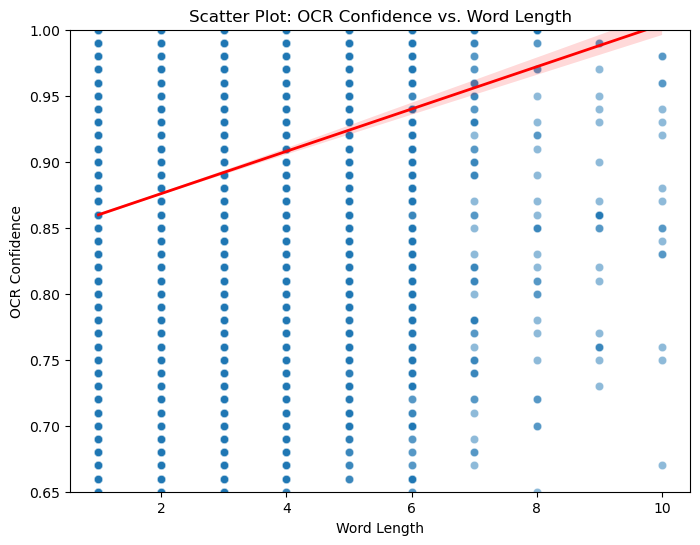

In [5]:
# plot 1: scatter plot of word length vs. OCR confidence
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_filtered["length"], y=df_filtered["confidence"], alpha=0.5)

# red regression line
sns.regplot(x=df_filtered["length"], y=df_filtered["confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# y-axis limit between 0.65 and 1 (because 0.65 minimum confidence set during data creation)
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length")

plt.show()

In [6]:
# filter words with more than 15 characters
long_words = df[df["word_JAP"].str.len() > 15][["word_JAP", "word_US"]]

print(long_words)

                   word_JAP                                word_US
10461      アニメパキスベシャルブックレット             Anime Paki Special Booklet
12679    ドユアチヨコレトユラボレツョンツャツ  Douya Chocolate Yura Bore Tsyon Paste
28671      チャンビオンコミックスエクストラ                  Champion Comics Extra
29251     テセソビオソユミックスエクスドラン             Tesse Sobio Soy Mix Exdran
29844    シヨンバキスペシャルブツクレツトベヅ         Shionbaki Special Booklet Bezu
31037  レアニメションバキスペシャルブックレット       Reanimation Baki Special Booklet
34091      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34206      チャンビオンコミツクスエクストラ                  Champion Comics Extra
34643     オリジナルチャンピオンマクワッペン             Original Champion McPappen


In [7]:
# jitter strength
jitter_strength = 0.1  # Adjust this value as needed

# create jittered columns
df_filtered["jittered_length"] = df_filtered["length"] + np.random.uniform(-jitter_strength, jitter_strength, len(df_filtered))
df_filtered["jittered_confidence"] = df_filtered["confidence"] + np.random.uniform(-jitter_strength, jitter_strength, len(df_filtered))


In [8]:
# KDE calculation using jittered values
xy = np.vstack([df_filtered['jittered_length'], df_filtered['jittered_confidence']])
kde = gaussian_kde(xy)  
density = kde(xy)  

# normalize density values
norm_density = (density - np.min(density)) / (np.max(density) - np.min(density))

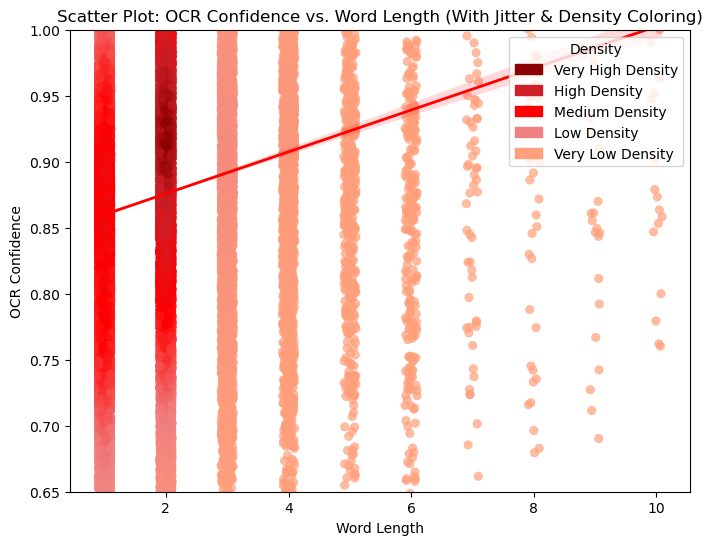

In [ ]:
# custom red palette (light red to dark red)
custom_reds = LinearSegmentedColormap.from_list(
    "custom_reds", ["#ffa07a", "#f08080", "#ff0000", "#ce2029", "#8b0000"]
)

# plot 1: scatter plot with density-based coloring
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_filtered["jittered_length"], 
    y=df_filtered["jittered_confidence"], 
    alpha=0.7, 
    hue=norm_density,
    palette=custom_reds,  # Apply custom red gradient
    edgecolor=None
)

# Regression line
sns.regplot(x=df_filtered["jittered_length"], y=df_filtered["jittered_confidence"], scatter=False, color="red", line_kws={"linewidth": 2})

# Set y-axis limit between 0.65 and 1
plt.ylim(0.65, 1)

plt.xlabel("Word Length")
plt.ylabel("OCR Confidence")
plt.title("Scatter Plot: OCR Confidence vs. Word Length (With Jitter & Density Coloring)")

legend_labels = [
    mpatches.Patch(color="#8b0000", label="Very High Density"),
    mpatches.Patch(color="#ce2029", label="High Density"),
    mpatches.Patch(color="#ff0000", label="Medium Density"),
    mpatches.Patch(color="#f08080", label="Low Density"),
    mpatches.Patch(color="#ffa07a", label="Very Low Density"),
]

plt.legend(handles=legend_labels, title="Density", loc="lower right")

plt.show()

C:\Users\andne\AppData\Local\Temp\ipykernel_15340\1703224322.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


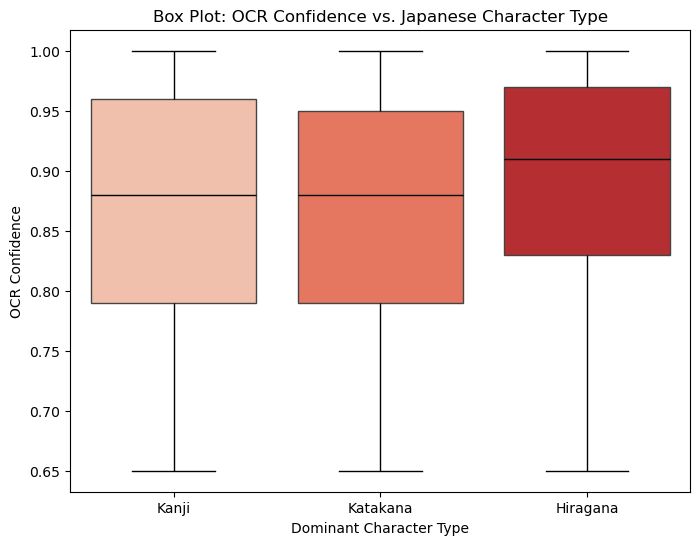

In [10]:
# function to find dominant character type
def classify_character_type(row):
    max_ratio = max(row["hiragana_ratio"], row["katakana_ratio"], row["kanji_ratio"])
    if max_ratio == row["kanji_ratio"]:
        return "Kanji"
    elif max_ratio == row["katakana_ratio"]:
        return "Katakana"
    else:
        return "Hiragana"

# apply classification
df_filtered["char_type"] = df_filtered.apply(classify_character_type, axis=1)

# plot 2: box plot
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="char_type", 
    y="confidence", 
    data=df_filtered, 
    palette="Reds",
    whiskerprops=dict(color="black"),  # whiskers
    capprops=dict(color="black"),  # caps
    medianprops=dict(color="black")  # median line
)

plt.xlabel("Dominant Character Type")
plt.ylabel("OCR Confidence")
plt.title("Box Plot: OCR Confidence vs. Japanese Character Type")

plt.show()

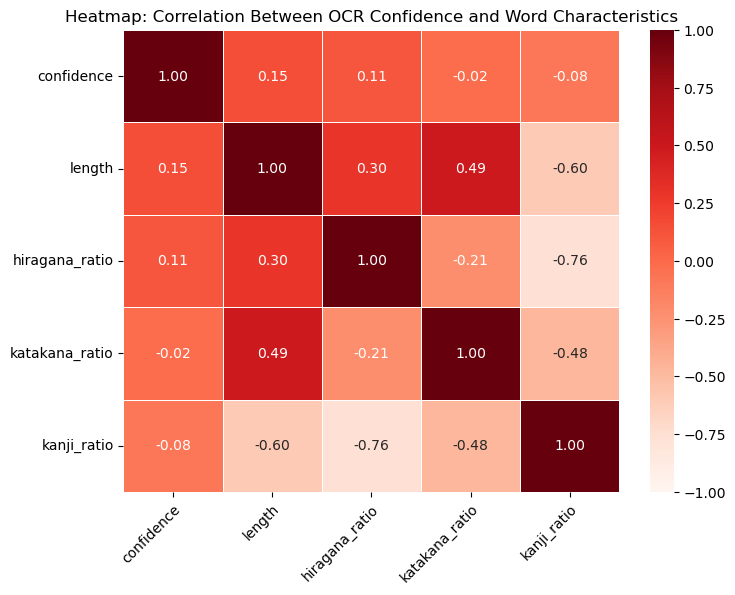

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# use only relevant numerical columns
correlation_data = df_filtered[["confidence", "length", "hiragana_ratio", "katakana_ratio", "kanji_ratio"]]

# correlation matrix
corr_matrix = correlation_data.corr()

# plot 3: heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,  # show correlation values
    cmap="Reds", 
    fmt=".2f",  # format numbers to 2 decimal places
    linewidths=0.5,  # add lines between cells for clarity
    vmin=-1, vmax=1  # ensure consistent color scaling
)

# tilt x axis names
plt.xticks(rotation=45, ha="right", rotation_mode="anchor", x=0.1)

plt.title("Heatmap: Correlation Between OCR Confidence and Word Characteristics")
plt.show()
